In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Activation, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from keras import regularizers, optimizers
from keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from keras.models import load_model
from tensorflow.keras.models import Model

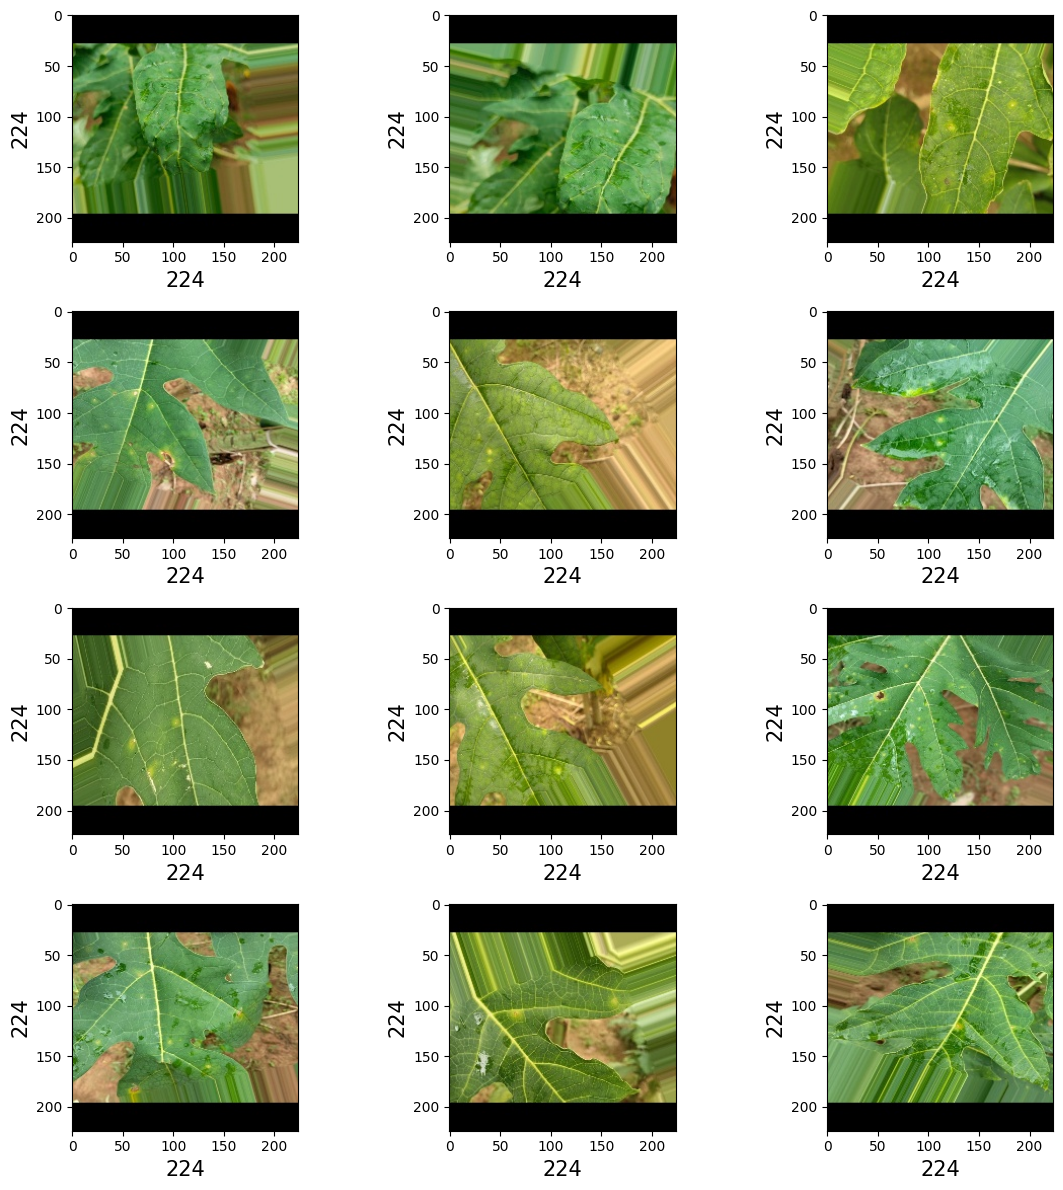

In [ ]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/Papya/RingSpot"
for i in range(1,13):
    plt.subplot(4,3,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 15)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 15)#height of image

In [ ]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (224,224))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
dir = "/content/drive/MyDrive/Papya"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['RingSpot', 'Healthy', 'Curl', 'BacterialSpot', 'Anthracnose']
binary_labels = [0, 1, 2, 3, 4]

# Reading and converting image to numpy array
for idx, directory in enumerate(root_dir):  # Using enumerate to handle indexing automatically
    plant_image_list = listdir(f"{dir}/{directory}")
    for files in plant_image_list:
        image_path = f"{dir}/{directory}/{files}"
        img_array = convert_image_to_array(image_path)
        if img_array is not None:  # Ensure the image was loaded correctly
            image_list.append(img_array)
            label_list.append(binary_labels[idx])  # Automatically assign the correct label

# Optionally print the loaded data summary
print(f"Loaded {len(image_list)} images across {len(all_labels)} classes.")

Loaded 4595 images across 5 classes.


In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

,count
0,
2,1070
3,922
4,882
1,861
0,860


In [ ]:
image_list[0].shape

(224, 224, 3)

In [ ]:
label_list = np.array(label_list)
label_list.shape

(4595,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.1, random_state = 10)

In [ ]:
#Normalizing the dataset
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape( -1, 224,224,3)
x_test = x_test.reshape( -1, 224,224,3)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
from keras.applications import MobileNet
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
last_layer = base_model.get_layer('conv_pw_13')  # Use the correct layer
print('last layer output shape:', last_layer.output.shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 1024)


In [ ]:
x = Flatten()(last_output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 54,815,941 (209.11 MB)

 Trainable params: 51,488,773 (196.41 MB)

 Non-trainable params: 3,327,168 (12.69 MB)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=.0001),metrics=['accuracy'])

In [ ]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Adjust the file extension to .keras
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/MobileNet_model.weights.best.keras',
                               verbose=1, save_best_only=True)

In [ ]:
# Training the model
epochs = 25
batch_size = 512
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val, y_val), callbacks=[checkpointer], verbose=2, shuffle=True)

Epoch 1/25

Epoch 1: val_loss improved from inf to 21.79711, saving model to /content/drive/MyDrive/Colab Notebooks/MobileNet_model.weights.best.keras
7/7 - 55s - 8s/step - accuracy: 0.9483 - loss: 19.8059 - val_accuracy: 0.5320 - val_loss: 21.7971
Epoch 2/25

Epoch 2: val_loss improved from 21.79711 to 21.05718, saving model to /content/drive/MyDrive/Colab Notebooks/MobileNet_model.weights.best.keras
7/7 - 65s - 9s/step - accuracy: 0.9797 - loss: 19.2218 - val_accuracy: 0.5562 - val_loss: 21.0572
Epoch 3/25

Epoch 3: val_loss improved from 21.05718 to 20.19465, saving model to /content/drive/MyDrive/Colab Notebooks/MobileNet_model.weights.best.keras
7/7 - 59s - 8s/step - accuracy: 0.9909 - loss: 18.5807 - val_accuracy: 0.6022 - val_loss: 20.1947
Epoch 4/25

Epoch 4: val_loss improved from 20.19465 to 19.26708, saving model to /content/drive/MyDrive/Colab Notebooks/MobileNet_model.weights.best.keras
7/7 - 51s - 7s/step - accuracy: 0.9967 - loss: 17.8870 - val_accuracy: 0.6155 - val_los

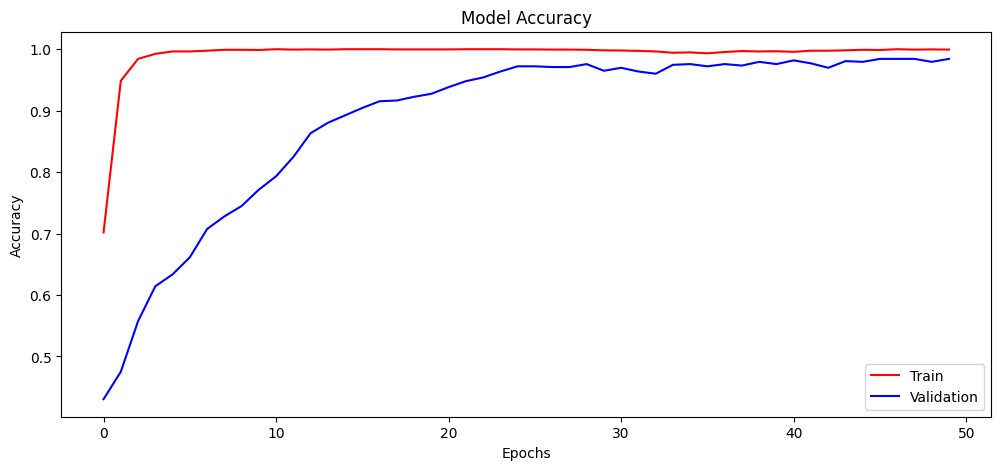

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])

plt.show()

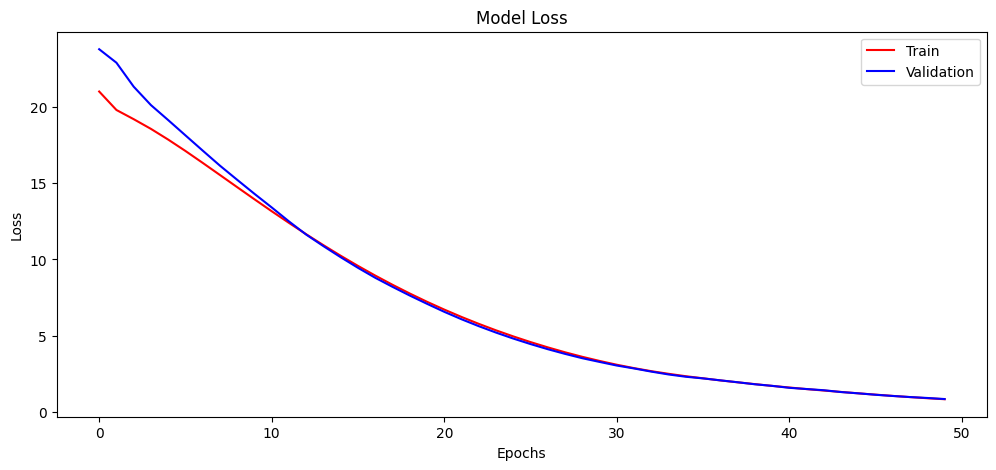

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.9722 - loss: 0.8481
Test Accuracy: 97.39130139350891


In [ ]:
#to terminate the kernel and free memory resources
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

In [ ]:
from keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Load the trained model
model_path = '/content/drive/MyDrive/Colab Notebooks/MobileNet_model.weights.best.keras'
model = load_model(model_path)

# Generate predictions on the test set
y_pred = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Calculate Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate other metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print individual metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        91
           1       0.97      0.98      0.97        97
           2       0.97      0.92      0.95       106
           3       0.98      0.81      0.89        79
           4       0.88      1.00      0.94        87

    accuracy                           0.94       460
   macro avg       0.94      0.94      0.94       460
weighted avg       0.94      0.94      0.94       460

Accuracy: 0.941304347826087
Precision: 0.9448176165073878
Recall: 0.941304347826087
F1 Score: 0.9405410081212511


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


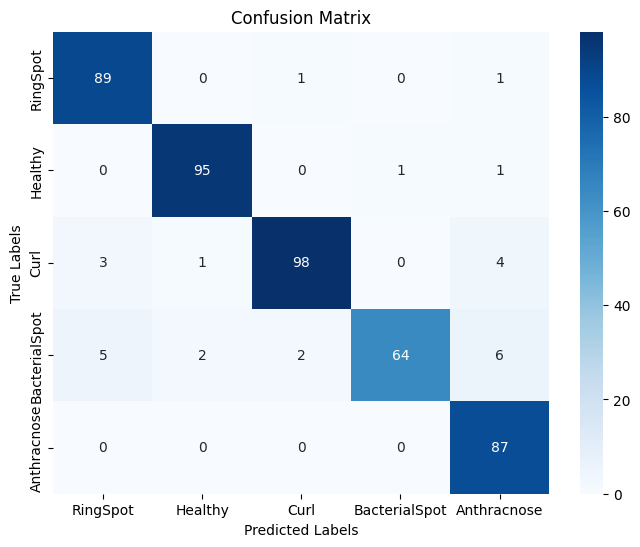

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
y_pred = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()